In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
from matplotlib import pyplot as plot

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Обработка данных

In [3]:
batch_size = 64

In [4]:
cifar_trainset = torchvision.datasets.CIFAR10(root='./dataset', train=True, download=True)
data = cifar_trainset.data / 255
mean = data.mean(axis = (0, 1, 2)) 
std = data.std(axis = (0, 1, 2))
print(f"Mean : {mean}   STD: {std}") 

Files already downloaded and verified
Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


In [5]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

train_dataset = torchvision.datasets.CIFAR10(root='./dataset', train=True, download=False, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [6]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

test_dataset = torchvision.datasets.CIFAR10(root='./dataset', train=False, download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f'Classes of dataset: {classes}')

Classes of dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Number of train samples: 50000
Number of test samples: 10000


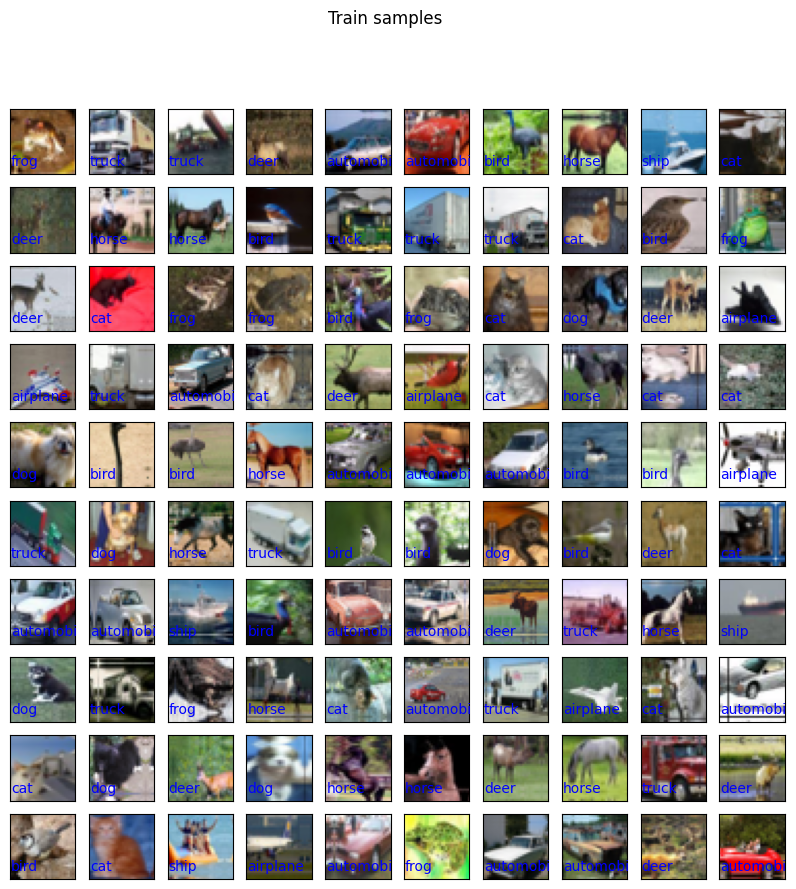

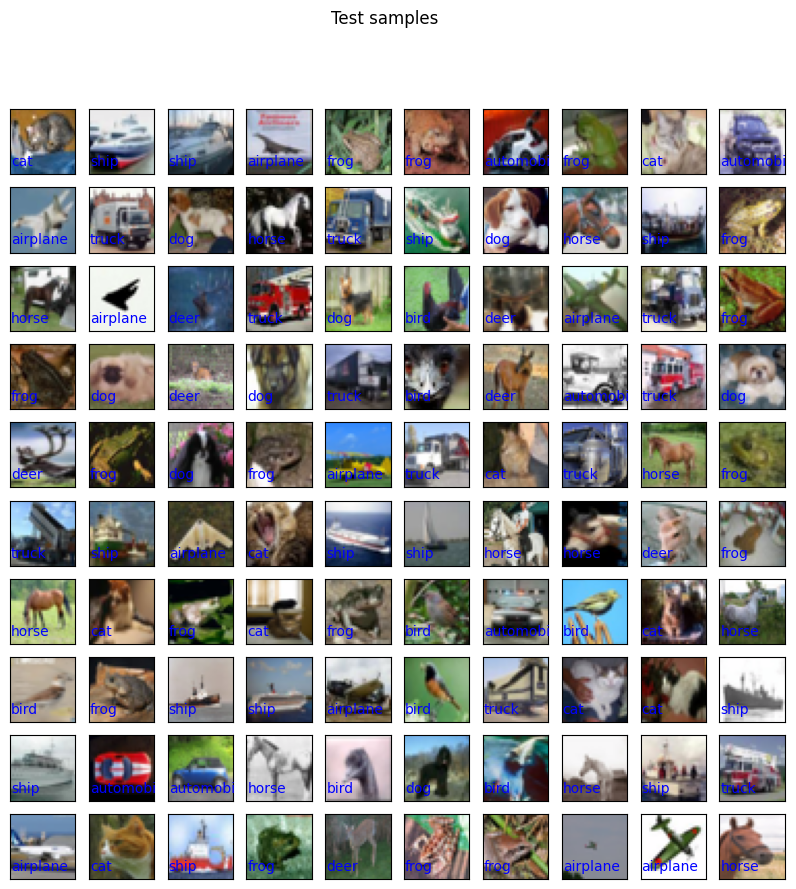

In [8]:
def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        original_img = images[i][0] * torch.tensor(std).reshape(3, 1, 1) + torch.tensor(mean).reshape(3, 1, 1)
        img = original_img.numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))
        ax.text(0, 27, str(classes[images[i][1]][:8]), color = 'b')

print(f'Number of train samples: {len(train_dataset)}')
show_images(train_dataset, 'Train samples')

print(f'Number of test samples: {len(test_dataset)}')
show_images(test_dataset, 'Test samples')

In [9]:
def get_shape(dataset):
  n = len(dataset)
  c, h, w = dataset[0][0].numpy().shape
  return [n, *(dataset[0][0].numpy().shape)]

print(f'Shape of input train data: {get_shape(train_dataset)}')
print(f'Shape of input test data: {get_shape(test_dataset)}')
print(f'Data type: {train_dataset[0][0].numpy().dtype}')

Shape of input train data: [50000, 3, 32, 32]
Shape of input test data: [10000, 3, 32, 32]
Data type: float32


In [10]:
data_shape = get_shape(train_dataset)
data_shape[0] = 1

## 2. Построение архитектуры сверточной сети

In [11]:
class Block(torch.nn.Module):
    def __init__(self, in_channel, cardinality=32, bottleneck_width=4, stride=1, factor=2):
        super(Block, self).__init__()
        self.factor = factor
        self.group_width = cardinality * bottleneck_width
        self.out_channel = self.factor * self.group_width
        self.conv1 = torch.nn.Conv2d(in_channel, self.group_width, kernel_size=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(self.group_width)
        self.group_conv2 = torch.nn.Conv2d(self.group_width, self.group_width, \
                                           kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(self.group_width)
        self.conv3 = torch.nn.Conv2d(self.group_width, self.out_channel, kernel_size=1, bias=False)
        self.bn3 = torch.nn.BatchNorm2d(self.out_channel)
        # to align shapes on the branches
        self.aligner = torch.nn.Sequential()
        if stride != 1 or in_channel != self.out_channel:
            self.aligner = torch.nn.Sequential(
                torch.nn.Conv2d(in_channel, self.out_channel, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(self.out_channel)
            )

    def forward(self, x):
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = torch.nn.functional.relu(self.bn2(self.group_conv2(out)))
        out = torch.nn.functional.relu(self.bn3(self.conv3(out)) + self.aligner(x))
        return out

In [12]:
class ResNeXt_32x4d(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(ResNeXt_32x4d, self).__init__()
        self.cardinality = 32
        self.bottleneck_width = 4
        self.channels = 64
        self.factor = 2
        self.count = 3

        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)

        self.stage0 = self._get_stage(3, 1)
        self.stage1 = self._get_stage(3, 2)
        self.stage2 = self._get_stage(3, 2)
        
        self.linear = torch.nn.Linear(self.cardinality * self.bottleneck_width, 10)

    def _get_stage(self, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        blocks = []
        for stride in strides:
            block = Block(self.channels, self.cardinality, self.bottleneck_width, stride, self.factor)
            self.channels = block.out_channel
            blocks.append(block)
        self.bottleneck_width *= 2
        return torch.nn.Sequential(*blocks)

    def forward(self, x):
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.stage0(out)
        out = self.stage1(out)
        out = self.stage2(out)
        out = torch.nn.functional.avg_pool2d(out, self.factor ** self.count)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [13]:
net_32x4d = ResNeXt_32x4d()
y_32x4d = net_32x4d(torch.rand(1,3,32,32))


(dot.exe:1020): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


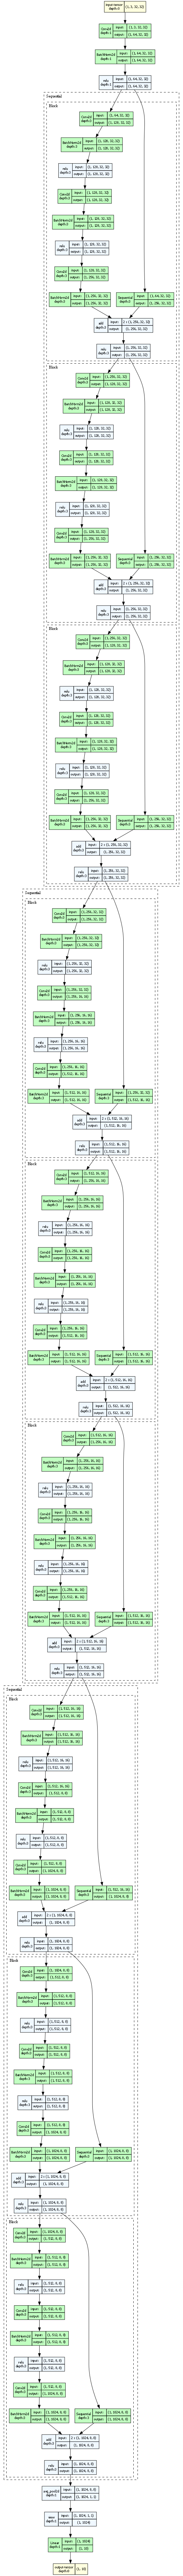

In [14]:
import graphviz
from torchview import draw_graph

graphviz.set_jupyter_format('png')
net_32x4d.to(device)
model_graph_32x4d = draw_graph(net_32x4d, input_size=data_shape, expand_nested=True, device=device)
model_graph_32x4d.visual_graph

## 3. Обучение сети

In [15]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

In [16]:
import time

def train(model, data_loader, epochs, loss_function, optimizer, device):
    for epoch in range(epoches):
        t0 = time.time()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            y = model(images)
            loss = loss_function(y, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        t1 = time.time()
        print(f'Epoch[{epoch + 1}]: accuracy = {get_accuracy(model, data_loader, device)}, time = {t1 - t0}')
    print(f'Test accuracy: {get_accuracy(model, data_loader, device)}')

In [17]:
learning_rate = 0.001
epoches = 30

model_32x4d = ResNeXt_32x4d()
model_32x4d = model_32x4d.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_32x4d.parameters(), lr = learning_rate)

train(model_32x4d, train_loader, epoches, loss_function, optimizer, device)
print(f'Validation accuracy: {get_accuracy(model_32x4d, test_loader, device)}')

Epoch[1]: accuracy = 0.6545799970626831, time = 738.6419062614441
Epoch[2]: accuracy = 0.7429999709129333, time = 643.0523645877838
Epoch[3]: accuracy = 0.803659975528717, time = 334.61915826797485
Epoch[4]: accuracy = 0.8243199586868286, time = 345.7864775657654
Epoch[5]: accuracy = 0.8427199721336365, time = 343.7310435771942
Epoch[6]: accuracy = 0.8672599792480469, time = 344.83863830566406
Epoch[7]: accuracy = 0.8850599527359009, time = 347.7442374229431
Epoch[8]: accuracy = 0.8948999643325806, time = 351.53794503211975
Epoch[9]: accuracy = 0.8981199860572815, time = 329.5133411884308
Epoch[10]: accuracy = 0.9022799730300903, time = 328.23957657814026
Epoch[11]: accuracy = 0.9174000024795532, time = 328.2678999900818
Epoch[12]: accuracy = 0.9160799980163574, time = 328.843220949173
Epoch[13]: accuracy = 0.9297999739646912, time = 329.20005464553833
Epoch[14]: accuracy = 0.9326799511909485, time = 328.56766748428345
Epoch[15]: accuracy = 0.940339982509613, time = 335.90943574905396
